In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [36]:


# 1. Define the filename (make sure you renamed it!)

#file_path = 'crsp_stock_returns_1985_2024.csv' # Or the new name if you renamed it
file_path = r"C:\Users\20202917\Downloads\nv1fehuuii7o8hjb.csv"

# 2. Read only the first 5 rows to see the columns
df_preview = pd.read_csv(file_path, nrows=5)

# 3. Show the columns and the first few rows
print("Columns in the file:")
print(df_preview.columns.tolist())

print("\nFirst 5 rows of data:")
display(df_preview)

Columns in the file:
['PERMNO', 'date', 'NAMEENDT', 'SHRCD', 'EXCHCD', 'SICCD', 'NCUSIP', 'TICKER', 'COMNAM', 'SHRCLS', 'TSYMBOL', 'NAICS', 'PRIMEXCH', 'TRDSTAT', 'SECSTAT', 'PERMCO', 'ISSUNO', 'HEXCD', 'HSICCD', 'CUSIP', 'DCLRDT', 'DLAMT', 'DLPDT', 'DLSTCD', 'NEXTDT', 'PAYDT', 'RCRDDT', 'SHRFLG', 'HSICMG', 'HSICIG', 'DISTCD', 'DIVAMT', 'FACPR', 'FACSHR', 'ACPERM', 'ACCOMP', 'SHRENDDT', 'NWPERM', 'DLRETX', 'DLPRC', 'DLRET', 'TRTSCD', 'NMSIND', 'MMCNT', 'NSDINX', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR', 'ALTPRC', 'SPREAD', 'ALTPRCDT', 'RETX', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']

First 5 rows of data:


,PERMNO,date,NAMEENDT,SHRCD,EXCHCD,SICCD,NCUSIP,TICKER,COMNAM,SHRCLS,...,CFACSHR,ALTPRC,SPREAD,ALTPRCDT,RETX,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.5625,NaN,1986-01-07,NaN,0.043061,0.040080,0.028021,0.026355,0.045061
1,10000,1986-01-31,1986-12-03,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.3750,0.250,1986-01-31,C,0.009830,0.008007,0.044071,0.043082,0.002367
2,10000,1986-02-28,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-3.2500,0.250,1986-02-28,-0.257143,0.072501,0.068191,0.060381,0.058938,0.071489
3,10000,1986-03-31,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.4375,0.125,1986-03-31,0.365385,0.053887,0.051362,0.047192,0.045679,0.052794
4,10000,1986-04-30,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.0000,0.250,1986-04-30,-0.098592,-0.007903,-0.009634,0.016140,0.015141,-0.014148


In [37]:
# data cleaning things..
raw = pd.read_excel("data_gpr_export.xls")
df = raw[["month", "GPR"]].copy()
df["month"] = pd.to_datetime(df["month"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["month", "GPR"]).sort_values("month").reset_index(drop=True)

# Make month the index 
df = df.set_index("month")
# definition simple difference shock: GPR_t - GPR_{t-1}
# here I just include a simple difference, to compare the AR to something
df["gpr_change"] = df["GPR"].diff()

# 2) AR(1): GPR_t = c + phi * GPR_{t-1} + u_t
gpr = df["GPR"]
gpr_lag = gpr.shift(1)

df["gpr_ar1_pred"] = np.nan
df["gpr_news_shock"] = np.nan


# Start once we have enough data to estimate, for the AR(1)
# Keep in mind we do not want to use future data to hedge ofc,
# Do we then use an expanding or moving window? Feel free to leave suggestions, gang
min_obs = 36 

for i in range(min_obs, len(df)):
    # Use data up to t-1 to fit AR(1)
    y_train = gpr.iloc[1:i]              
    x_train = gpr_lag.iloc[1:i]          
    train = pd.concat([y_train, x_train], axis=1).dropna()

    y = train.iloc[:, 0]
    x = sm.add_constant(train.iloc[:, 1])

    model = sm.OLS(y, x).fit()

    # One-step-ahead prediction for time t
    x_t = sm.add_constant(pd.Series([gpr_lag.iloc[i]], index=["x"]), has_constant="add")
    # Align names to model params
    x_t = pd.DataFrame({"const": [1.0], train.columns[1]: [gpr_lag.iloc[i]]})

    gpr_hat_t = float(model.predict(x_t)[0])
    shock_t = float(gpr.iloc[i] - gpr_hat_t)

    df.iloc[i, df.columns.get_loc("gpr_ar1_pred")] = gpr_hat_t
    df.iloc[i, df.columns.get_loc("gpr_news_shock")] = shock_t

# --- Standardize shocks WITHOUT using future info (strict "known at t-1") ---

# 1) gpr_change_z (optional, but make it consistent)
mu_chg = df["gpr_change"].expanding(min_periods=min_obs).mean().shift(1)
sd_chg = df["gpr_change"].expanding(min_periods=min_obs).std().shift(1)
df["gpr_change_z"] = (df["gpr_change"] - mu_chg) / sd_chg

# 2) gpr_news_shock_z (this is the main one)
mu_shk = df["gpr_news_shock"].expanding(min_periods=min_obs).mean().shift(1)
sd_shk = df["gpr_news_shock"].expanding(min_periods=min_obs).std().shift(1)
df["gpr_news_shock_z"] = (df["gpr_news_shock"] - mu_shk) / sd_shk

# --- Create ONE clean merge table with a DATE COLUMN (month-end) ---
# Right now df has month as index. We convert it into a normal 'date' column.

df_gpr_merge = df.reset_index().rename(columns={"month": "date"})
df_gpr_merge["date"] = pd.to_datetime(df_gpr_merge["date"], errors="coerce") + MonthEnd(0)

# Keep only what you need for merges
df_gpr_merge = df_gpr_merge[
    ["date", "GPR", "gpr_change", "gpr_change_z", "gpr_ar1_pred", "gpr_news_shock", "gpr_news_shock_z"]
].copy()

# Drop rows where z-score not available yet (early months)
df_gpr_merge = df_gpr_merge.dropna(subset=["gpr_news_shock_z"]).sort_values("date").reset_index(drop=True)

print("GPR merge table ready:", df_gpr_merge.shape)
display(df_gpr_merge.tail())


GPR merge table ready: (420, 7)


,date,GPR,gpr_change,gpr_change_z,gpr_ar1_pred,gpr_news_shock,gpr_news_shock_z
415,2025-08-31,136.759415,1.755157,0.047619,126.131691,10.627724,0.315378
416,2025-09-30,124.114983,-12.644432,-0.359158,127.436132,-3.321149,-0.086007
417,2025-10-31,154.425201,30.310219,0.855632,118.259686,36.165515,1.050500
418,2025-11-30,105.251610,-49.173592,-1.393598,140.342169,-35.090559,-1.002426
419,2025-12-31,127.319107,22.067497,0.623270,104.585471,22.733636,0.663749


In [38]:

# We ADD 'shrcd' to the columns we need to load
cols_needed = ['permno', 'date', 'ret', 'prc', 'shrout', 'siccd', 'dlret', 'shrcd']

df_stocks_clean = pd.read_csv(
    file_path, 
    usecols=lambda x: x.lower() in cols_needed, 
    low_memory=False
)
df_stocks_clean.columns = df_stocks_clean.columns.str.lower()

# --- SAMUEL'S FILTER: Keep only Common Shares (10 & 11) ---
print(f"Rows before filter: {len(df_stocks_clean)}")
df_stocks_clean = df_stocks_clean[df_stocks_clean['shrcd'].isin([10, 11])].copy()
print(f"Rows after keeping only Common Shares (10, 11): {len(df_stocks_clean)}")

# Fix Dates
df_stocks_clean['date'] = pd.to_datetime(df_stocks_clean['date'], errors='coerce') + MonthEnd(0)

# Force Numeric Types
for col in ['ret', 'dlret', 'prc', 'shrout']:
    df_stocks_clean[col] = pd.to_numeric(df_stocks_clean[col], errors='coerce')

# --- Calculate "True" Returns (Delisting Adjustment) ---
# df_stocks_clean['ret'] = df_stocks_clean['ret'].fillna(0)
# df_stocks_clean['dlret'] = df_stocks_clean['dlret'].fillna(0)
# df_stocks_clean['ret_adj'] = (1 + df_stocks_clean['ret']) * (1 + df_stocks_clean['dlret']) - 1

# --- Calculate "True" Returns (Delisting Adjustment) WITHOUT fake 0% months ---

ret = df_stocks_clean['ret']
dlret = df_stocks_clean['dlret']

# If RET exists, combine it with DLRET (missing DLRET treated as 0)
ret_adj = (1 + ret) * (1 + dlret.fillna(0)) - 1

# If RET is missing but DLRET exists (delisting month), use DLRET
mask_delist_only = ret.isna() & dlret.notna()
ret_adj.loc[mask_delist_only] = dlret.loc[mask_delist_only]

# If both are missing, keep NaN (we will drop)
mask_both_missing = ret.isna() & dlret.isna()
ret_adj.loc[mask_both_missing] = np.nan

df_stocks_clean['ret_adj'] = ret_adj

# Drop missing ret_adj (removes the fake 0% return months)
df_stocks_clean = df_stocks_clean.dropna(subset=['ret_adj'])

# --- Winsorize returns BY MONTH (1% / 99%) to kill extreme outliers ---
# This prevents crazy months like +2658% from destroying betas and hedge regressions.

lo = df_stocks_clean.groupby('date')['ret_adj'].transform(lambda s: s.quantile(0.01))
hi = df_stocks_clean.groupby('date')['ret_adj'].transform(lambda s: s.quantile(0.99))

df_stocks_clean['ret_adj'] = df_stocks_clean['ret_adj'].clip(lower=lo, upper=hi)

print("After winsorization:")
print("Max ret_adj:", df_stocks_clean['ret_adj'].max())
print("Min ret_adj:", df_stocks_clean['ret_adj'].min())


# --- Calculate Market Cap ---
df_stocks_clean['mktcap'] = df_stocks_clean['prc'].abs() * df_stocks_clean['shrout']

# Drop invalid rows
df_stocks_clean = df_stocks_clean.dropna(subset=['permno', 'date', 'ret_adj', 'mktcap'])

print("Stock data cleaned successfully.")

# --- 2. Get Fama-French Factors ---
# (This part stays the same, just re-running to be safe)
ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
ff3 = ff3.reset_index().rename(columns={'Date': 'date'})
ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100.0
ff3['date'] = ff3['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start='1985', end='2025')[0]
mom = mom.reset_index().rename(columns={'Date': 'date'})
mom[['Mom']] = mom[['Mom']] / 100.0
mom['date'] = mom['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

factors = ff3.merge(mom, on='date', how='inner')

# --- 3. Merge Everything ---
# Ensure df_gpr_merge is ready (from your previous GPR step)
# if 'df_gpr_merge' not in globals():
    # Fallback if variable name was lost, assuming 'df' is your GPR dataframe
  #  df_gpr_merge = df.copy()
   # df_gpr_merge = df_gpr_merge.rename(columns={'month': 'date'})
    #df_gpr_merge['date'] = pd.to_datetime(df_gpr_merge['date']) + MonthEnd(0)

df_master_clean = df_stocks_clean.merge(factors, on='date', how='inner')
df_master_clean = df_master_clean.merge(df_gpr_merge[['date', 'gpr_news_shock_z']], on='date', how='inner')
df_master_clean['excret'] = df_master_clean['ret_adj'] - df_master_clean['RF']
df_master_clean = df_master_clean.dropna(subset=['gpr_news_shock_z'])

print("After ret_adj fix:")
print("Max ret_adj:", df_stocks_clean['ret_adj'].max())
print("Min ret_adj:", df_stocks_clean['ret_adj'].min())

print("Master dataset ready with Common Shares only!")

Rows before filter: 3720048
Rows after keeping only Common Shares (10, 11): 2513725
After winsorization:
Max ret_adj: 2.1746859199999977
Min ret_adj: -0.7214908400000001
Stock data cleaned successfully.


C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\467298092.py:72: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\467298092.py:72: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\467298092.py:77: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  m

After ret_adj fix:
Max ret_adj: 2.1746859199999977
Min ret_adj: -0.7214908400000001
Master dataset ready with Common Shares only!


In [39]:

# 1. CRITICAL FIX: Sort by Permno and Date
# This ensures that when we roll 60 months back, we are actually looking at the PAST 60 months.
df_master_clean = df_master_clean.sort_values(['permno', 'date'])

# 2. Define the Rolling Function
def rolling_beta_pipeline(group):
    exog_vars = ['Mkt-RF', 'SMB', 'HML', 'Mom', 'gpr_news_shock_z']

    # Keep only rows where regression inputs exist
    g = group[['excret'] + exog_vars].dropna()

    # Output container aligned to original group index
    out = pd.DataFrame(index=group.index, columns=['beta_gpr', 'beta_se'], dtype=float)

    # Need enough data to run a 60m rolling window
    if len(g) < 60:
        return out

    endog = g['excret']
    exog = sm.add_constant(g[exog_vars])

    rols = RollingOLS(endog, exog, window=60, min_nobs=36)
    rres = rols.fit()

    beta = rres.params['gpr_news_shock_z']
    se   = rres.bse['gpr_news_shock_z']

    # Put results back onto original index positions
    out.loc[beta.index, 'beta_gpr'] = beta
    out.loc[se.index,   'beta_se'] = se
    return out



print("Starting Rolling Beta estimation. This may take 5-10 minutes...")

# 3. Apply the function
# group_keys=False keeps the original index so we can assign it back easily
# df_master_clean['beta_gpr'] = df_master_clean.groupby('permno', group_keys=False).apply(rolling_beta_pipeline)

# --- cleanup: remove old beta columns if they exist (from previous runs) ---
df_master_clean = df_master_clean.drop(
    columns=['beta_gpr', 'beta_se', 'beta_gpr_lag', 'beta_se_lag'],
    errors='ignore'
)

tmp = df_master_clean.groupby('permno', group_keys=False).apply(rolling_beta_pipeline)
df_master_clean = df_master_clean.join(tmp)


# 4. Lag the Beta
# We use the beta estimated using data up to month t-1 to make decisions in month t.
#df_master_clean['beta_gpr_lag'] = df_master_clean.groupby('permno')['beta_gpr'].shift(1)

# 5. Create Analysis Set
# Drop rows where we don't have a beta yet (the first 5 years for each firm)
# df_analysis = df_master_clean.dropna(subset=['beta_gpr_lag']).copy()

df_master_clean = df_master_clean.sort_values(['permno', 'date'])

df_master_clean['beta_gpr_lag'] = df_master_clean.groupby('permno')['beta_gpr'].shift(1)
df_master_clean['beta_se_lag']  = df_master_clean.groupby('permno')['beta_se'].shift(1)

# Analysis set: must have lagged beta + lagged SE
df_analysis = df_master_clean.dropna(subset=['beta_gpr_lag', 'beta_se_lag']).copy()

print(df_analysis[['beta_gpr_lag','beta_se_lag']].describe())


print(df_analysis['beta_gpr_lag'].describe())
print("Step 1 Complete!")
print(f"Rows with valid Betas: {len(df_analysis)}")
display(df_analysis[['date', 'permno', 'beta_gpr', 'beta_gpr_lag']].head())

Starting Rolling Beta estimation. This may take 5-10 minutes...


C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\3539487558.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = df_master_clean.groupby('permno', group_keys=False).apply(rolling_beta_pipeline)


       beta_gpr_lag   beta_se_lag
count  1.135586e+06  1.135586e+06
mean  -4.156990e-04  3.093901e-02
std    3.780365e-02  2.144654e-02
min   -3.843843e-01  1.700677e-03
25%   -1.524040e-02  1.413593e-02
50%    1.232096e-04  2.547583e-02
75%    1.500331e-02  4.310104e-02
max    3.028706e-01  1.582857e-01
count    1.135586e+06
mean    -4.156990e-04
std      3.780365e-02
min     -3.843843e-01
25%     -1.524040e-02
50%      1.232096e-04
75%      1.500331e-02
max      3.028706e-01
Name: beta_gpr_lag, dtype: float64
Step 1 Complete!
Rows with valid Betas: 1135586


,date,permno,beta_gpr,beta_gpr_lag
60,1995-12-31,10001,0.007867,0.004902
61,1996-01-31,10001,0.004723,0.007867
62,1996-02-29,10001,-0.002918,0.004723
63,1996-03-31,10001,0.000341,-0.002918
64,1996-04-30,10001,0.002743,0.000341


In [40]:
#cell 5.5 step 1.5
print("Applying Vasicek shrinkage (monthly cross-sectional)...")

def vasicek_shrink_month(g):
    prior_var  = g['beta_gpr_lag'].var()
    prior_mean = g['beta_gpr_lag'].mean()

    # If something degenerate happens, don't shrink
    if pd.isna(prior_var) or prior_var == 0:
        return g['beta_gpr_lag']

    meas_var = g['beta_se_lag'] ** 2  # estimation noise
    w = prior_var / (prior_var + meas_var)
    w = w.clip(0, 1)

    return w * g['beta_gpr_lag'] + (1 - w) * prior_mean

df_analysis['beta_gpr_shrunk_lag'] = df_analysis.groupby('date', group_keys=False).apply(vasicek_shrink_month)

print("Raw vs Shrunk (lagged) beta summary:")
print(df_analysis[['beta_gpr_lag','beta_gpr_shrunk_lag']].describe().loc[['mean','std','min','max']])


Applying Vasicek shrinkage (monthly cross-sectional)...
Raw vs Shrunk (lagged) beta summary:
      beta_gpr_lag  beta_gpr_shrunk_lag
mean     -0.000416            -0.000250
std       0.037804             0.017904
min      -0.384384            -0.130502
max       0.302871             0.126127


C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\1799005222.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis['beta_gpr_shrunk_lag'] = df_analysis.groupby('date', group_keys=False).apply(vasicek_shrink_month)


In [41]:
# --- Step 2: Sort Firms and Construct Portfolios (The "Bulletproof" Version) ---

print("Sorting firms into deciles...")

# 1. CRITICAL FIX: Lag Market Cap
# We must weight Feb returns using Jan Market Cap to avoid look-ahead bias.
df_analysis = df_analysis.sort_values(['permno', 'date'])
df_analysis['mktcap_lag'] = df_analysis.groupby('permno')['mktcap'].shift(1)

# Drop the first month for each firm (since we don't have a lagged cap for it)
df_analysis = df_analysis.dropna(subset=['mktcap_lag'])

# 2. Keep only months with enough firms to form stable deciles
min_firms_per_month = 200  # you can raise this to 300 if you want stricter
month_counts = df_analysis.groupby('date')['permno'].transform('size')
df_analysis = df_analysis[month_counts >= min_firms_per_month].copy()

# 3. Sort into 10 Deciles based on LAGGED Beta (only on valid months now)
df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(
    lambda g: pd.qcut(g['beta_gpr_shrunk_lag'], 10, labels=False, duplicates='drop')
)


# 3. Robust Value-Weighted Mean Function
def vw_mean_robust(g):
    # Get weights (Lagged Cap) and Returns
    w = g['mktcap_lag']
    # r = g['ret_adj']
    r = g['excret']
    
    # Filter out any missing values or zero weights
    mask = w.notna() & r.notna() & (w > 0)
    w = w[mask]
    r = r[mask]
    
    # Safety: If no valid data, return NaN
    if len(w) == 0 or w.sum() == 0:
        return np.nan
        
    # Weighted Average
    return np.average(r, weights=w)

print("Calculating Value-Weighted Portfolio Returns...")

# 4. Calculate Portfolio Returns
port_rets = df_analysis.groupby(['date', 'decile']).apply(vw_mean_robust).unstack()

# Ensure we have columns for all 10 deciles (0..9). Missing ones become NaN.
port_rets = port_rets.reindex(columns=range(10))

# Keep only months where ALL 10 portfolios exist
port_rets = port_rets.dropna()

# Now rename safely
port_rets.columns = [f'P{i+1}' for i in range(10)]


# 6. Add Factors Back (for Step 3)
port_rets = port_rets.merge(factors.set_index('date'), left_index=True, right_index=True)


counts = df_analysis.groupby(['date','decile']).size().unstack()
print("Any months missing a decile?", counts.isna().any(axis=1).sum())
print("Min firms per decile in any month:", counts.min().min())
print("Max firms per decile in any month:", counts.max().max())

avg_returns = port_rets[[f'P{i}' for i in range(1,11)]].mean()
print("Average portfolio excess returns (P1..P10):")
print(avg_returns)


# Additional checks:

P = port_rets[[f'P{i}' for i in range(1, 11)]]

# Correlation matrix (if two columns are identical, corr will be 1.0)
corr = P.corr()
display(corr)

eq_months = (port_rets['P9'] == port_rets['P10'])
print("Months where P9 == P10 exactly:", int(eq_months.sum()))

# Show those months if any
if eq_months.any():
    display(port_rets.loc[eq_months, ['P9','P10']].head(20))

diff = (port_rets['P10'] - port_rets['P9']).abs()
print(diff.describe())

print("Months where |P10-P9| < 1e-10:", int((diff < 1e-10).sum()))


print("Step 2 Complete! Portfolio Returns (Lagged VW) Ready.")
display(port_rets.head())

Sorting firms into deciles...


C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\4163563029.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(


Calculating Value-Weighted Portfolio Returns...
Any months missing a decile? 0
Min firms per decile in any month: 49
Max firms per decile in any month: 395
Average portfolio excess returns (P1..P10):
P1     0.008350
P2     0.005122
P3     0.007021
P4     0.007758
P5     0.009197
P6     0.008187
P7     0.007567
P8     0.007731
P9     0.008605
P10    0.007747
dtype: float64


C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\4163563029.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_rets = df_analysis.groupby(['date', 'decile']).apply(vw_mean_robust).unstack()


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
P1,1.000000,0.849899,0.847835,0.835639,0.822022,0.822851,0.797495,0.772788,0.740578,0.733875
P2,0.849899,1.000000,0.851219,0.851206,0.844185,0.874151,0.821732,0.813242,0.801690,0.780743
P3,0.847835,0.851219,1.000000,0.837929,0.858891,0.845162,0.801256,0.790625,0.768754,0.795321
P4,0.835639,0.851206,0.837929,1.000000,0.838483,0.846312,0.819897,0.803166,0.775446,0.784585
P5,0.822022,0.844185,0.858891,0.838483,1.000000,0.852976,0.839291,0.816907,0.794745,0.796046
P6,0.822851,0.874151,0.845162,0.846312,0.852976,1.000000,0.846951,0.858503,0.835800,0.822669
P7,0.797495,0.821732,0.801256,0.819897,0.839291,0.846951,1.000000,0.834949,0.825947,0.836120
P8,0.772788,0.813242,0.790625,0.803166,0.816907,0.858503,0.834949,1.000000,0.816472,0.843217
P9,0.740578,0.801690,0.768754,0.775446,0.794745,0.835800,0.825947,0.816472,1.000000,0.841970
P10,0.733875,0.780743,0.795321,0.784585,0.796046,0.822669,0.836120,0.843217,0.841970,1.000000


Months where P9 == P10 exactly: 0
count    348.000000
mean       0.020359
std        0.018787
min        0.000038
25%        0.007436
50%        0.015345
75%        0.027656
max        0.116950
dtype: float64
Months where |P10-P9| < 1e-10: 0
Step 2 Complete! Portfolio Returns (Lagged VW) Ready.


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,Mkt-RF,SMB,HML,RF,Mom
date,,,,,,,,,,,,,,,
1996-01-31,0.001128,0.026787,0.037030,-0.000931,0.023132,0.032851,-0.008259,0.016193,0.042715,0.015998,0.0226,-0.0283,0.0046,0.0043,0.0057
1996-02-29,0.006509,0.019175,-0.011138,-0.008858,0.016108,0.017459,0.016173,0.019157,0.010716,0.047694,0.0133,0.0179,-0.0105,0.0039,0.0057
1996-03-31,-0.000210,0.014133,-0.006140,-0.015600,-0.000547,0.021749,0.027771,0.018200,0.018739,-0.001875,0.0074,0.0143,0.0042,0.0039,-0.0185
1996-04-30,0.030608,-0.007042,0.018290,0.035181,0.011629,-0.001340,0.020446,0.026878,0.009784,0.009722,0.0206,0.0520,-0.0397,0.0046,-0.0094
1996-05-31,0.020958,0.022564,0.011767,0.036644,0.022620,0.028034,0.009614,0.015480,0.019184,0.002686,0.0236,0.0320,-0.0090,0.0042,0.0162


In [42]:

print("Starting: Constrained Optimization Hedge (36m Window + IS/OOS Check)")


# ==========================================
# 1. Data Alignment & Setup (SAFE: no mutation + no double RF subtraction)
# ==========================================

# Use the SAME shock you used earlier
shock_col = 'gpr_news_shock_z'
print(f"Using shock column: {shock_col}")

port_cols = [f'P{i}' for i in range(1, 11)]
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'Mom']

# Make safe temporary copies (do NOT mutate df_gpr_merge / port_rets)
gpr_tmp = df_gpr_merge[['date', shock_col]].copy()
gpr_tmp['date'] = pd.to_datetime(gpr_tmp['date']) + MonthEnd(0)

port_tmp = port_rets.reset_index().copy()  # port_rets uses date as index
port_tmp['date'] = pd.to_datetime(port_tmp['date']) + MonthEnd(0)

# Merge on date (clean and consistent)
df_all = (
    gpr_tmp.merge(port_tmp, on='date', how='inner')
           .dropna()
           .sort_values('date')
           .set_index('date')
)

# IMPORTANT: P1..P10 are ALREADY excess returns because you used excret in Cell 6.
# So do NOT subtract RF again.

print(f"Data Range: {df_all.index.min()} to {df_all.index.max()} (n={len(df_all)})")


# ==========================================
# 2. Rolling Optimization (36 Months)
# ==========================================
rolling_window = 60   # Faster adaptation to beta drift
min_obs = 60          # Start sooner
ridge_lam = 200.0       # Higher penalty to stabilize weights

results_oos = []
weights_hist = []

if len(df_all) > min_obs:
    print(f"Starting loop (Window={rolling_window}m, Ridge={ridge_lam})...")

    for t in range(min_obs, len(df_all)):
        # --- A. Rolling Window ---
        start_idx = t - rolling_window
        if start_idx < 0: start_idx = 0
        
        train = df_all.iloc[start_idx:t].copy()
        
        # --- B. Standardize Inputs (Crucial for Ridge) ---
        # 1. Target (Shock)
        shock_raw = train[shock_col]
        shock_mean = shock_raw.mean()
        shock_std = shock_raw.std()
        if shock_std == 0: shock_std = 1
        y_train = ((shock_raw - shock_mean) / shock_std).values
        
        # 2. Features (Portfolios) - Standardize X for the optimization math
        X_raw = train[port_cols].values
        X_mean = X_raw.mean(axis=0)
        X_std = X_raw.std(axis=0)
        X_std[X_std == 0] = 1.0 # Safety
        X_train = (X_raw - X_mean) / X_std
        
        # 3. Factors (for Constraints)
        F_train = sm.add_constant(train[factor_cols]).values
        
        # --- C. Factor-neutrality constraint matrix ---
        # We want hedge = X_train @ w to have ~0 covariance with factors.
        # Constraint: (F'X) w = 0   using factors WITHOUT the intercept.
        try:
            Constraint_Matrix = (F_train[:, 1:].T @ X_train)  # shape (4, 10)
        except Exception:
            continue

        
        # --- D. KKT Solver ---
        N = X_train.shape[1]
        K = Constraint_Matrix.shape[0]
        
        # H = 2(X'X + lam*I)
        H = 2 * (X_train.T @ X_train + ridge_lam * np.eye(N))
        c = 2 * X_train.T @ y_train
        
        # Build KKT
        top = np.hstack([H, Constraint_Matrix.T])
        bot = np.hstack([Constraint_Matrix, np.zeros((K, K))])
        KKT = np.vstack([top, bot])
        
        rhs = np.concatenate([c, np.zeros(K)])
        
        try:
            sol = np.linalg.solve(KKT, rhs)
            w_std = sol[:N] # Weights for STANDARDIZED portfolios
        except np.linalg.LinAlgError:
            w_std = np.zeros(N)

        # --- E. In-Sample Correlation Check ---
        # How well does the hedge track the shock inside the training set?
        pred_is = np.dot(X_train, w_std)
        if np.std(pred_is) > 1e-9:
            corr_is = np.corrcoef(pred_is, y_train)[0, 1]
        else:
            corr_is = 0.0
            
        # --- F. Out-of-Sample Execution ---
        # Convert weights back to raw scale
        w_raw = w_std / X_std
        
        # Hedge Return
        r_t_raw = df_all[port_cols].iloc[t].values
        hedge_ret = np.dot(w_raw, r_t_raw)
        
        # Store results
        shock_val_t = df_all[shock_col].iloc[t]
        shock_z_oos = (shock_val_t - shock_mean) / shock_std
        
        results_oos.append({
            'date': df_all.index[t],
            'Hedge_Ret': hedge_ret,
            'Shock_Z_OOS': shock_z_oos,
            'IS_Corr': corr_is,
            'Gross_Leverage': np.sum(np.abs(w_raw))
        })
        weights_hist.append(pd.Series(w_raw, index=port_cols, name=df_all.index[t]))

# ==========================================
# 3. Final Diagnostic
# ==========================================
if len(results_oos) > 0:
    df_res = pd.DataFrame(results_oos).set_index('date')
    df_w = pd.DataFrame(weights_hist)
    
    # 1. Correlations
    avg_is = df_res['IS_Corr'].mean()
    corr_oos = df_res['Hedge_Ret'].corr(df_res['Shock_Z_OOS'])
    
    print("\n" + "="*40)
    print(f"AVERAGE IN-SAMPLE CORRELATION:  {avg_is:.4f}")
    print(f"FINAL OUT-OF-SAMPLE CORRELATION: {corr_oos:.4f}")
    print("="*40)
    
    # 2. Factor Neutrality Check
    diag = df_res.join(df_all[factor_cols], how='inner')
    model = sm.OLS(diag['Hedge_Ret'], sm.add_constant(diag[factor_cols]))
    res = model.fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    
    print("\nDiagnostic Regression (Goal: All Factor P-values > 0.05)")
    print(res.summary())
    
    # 3. Weights and Leverage
    print("\nMost Recent Weights:")
    print(df_w.iloc[-1].round(4))
    
    print("\nLast 5 Months Performance:")
    print(df_res[['Hedge_Ret', 'Shock_Z_OOS', 'IS_Corr', 'Gross_Leverage']].tail())
    
    # Interpretation Helper
    if avg_is > 0.4 and corr_oos < 0.1:
        print("\n[WARNING] Overfitting: High IS correlation but low OOS correlation.")
    elif avg_is < 0.1:
        print("\n[WARNING] Weak Signal: Portfolios struggle to track shock even In-Sample.")
    else:
        print("\n[INFO] Model looks stable (IS and OOS are reasonably aligned).")

else:
    print("No results generated.")

print(df_res['Hedge_Ret'].corr(df_res['Shock_Z_OOS']))
print((-df_res['Hedge_Ret']).corr(df_res['Shock_Z_OOS']))

print("OOS corr:", df_res['Hedge_Ret'].corr(df_res['Shock_Z_OOS']))
print("Gross leverage summary:")
print(df_res['Gross_Leverage'].describe())

tmp = df_all.dropna().copy()
y = tmp['gpr_news_shock_z']
X = sm.add_constant(tmp[[f'P{i}' for i in range(1,11)]])
res = sm.OLS(y, X).fit()
print(res.rsquared)
print(res.summary())



Starting: Constrained Optimization Hedge (36m Window + IS/OOS Check)
Using shock column: gpr_news_shock_z
Data Range: 1996-01-31 00:00:00 to 2024-12-31 00:00:00 (n=348)
Starting loop (Window=60m, Ridge=200.0)...

AVERAGE IN-SAMPLE CORRELATION:  0.3015
FINAL OUT-OF-SAMPLE CORRELATION: -0.0034

Diagnostic Regression (Goal: All Factor P-values > 0.05)
                            OLS Regression Results                            
Dep. Variable:              Hedge_Ret   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                    0.6652
Date:                Tue, 20 Jan 2026   Prob (F-statistic):              0.617
Time:                        12:33:40   Log-Likelihood:                 812.17
No. Observations:                 288   AIC:                            -1614.
Df Residuals:                     283   BIC:                            -1596.
Df Model:        

In [ ]:


# Align factors to hedge dates
df_reg = final_oos.join(df_step[['Mkt-RF','SMB','HML','Mom']], how='inner').dropna()

Y = df_reg['Hedge_Excess_Return']
X = sm.add_constant(df_reg[['Mkt-RF','SMB','HML','Mom']])

res = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})  # HAC is standard for monthly data
print(res.summary())


NameError: name 'df_step' is not defined

In [123]:
df_reg2 = final_oos.join(df_step[['Mkt-RF','SMB','HML','Mom']], how='inner').dropna()

Y = df_reg2['Hedge_Excess_Return']
X = sm.add_constant(pd.concat([df_reg2['GPR_Shock_Z_OOS'], df_reg2[['Mkt-RF','SMB','HML','Mom']]], axis=1))

res2 = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(res2.summary())


                             OLS Regression Results                            
Dep. Variable:     Hedge_Excess_Return   R-squared:                       0.448
Model:                             OLS   Adj. R-squared:                  0.438
Method:                  Least Squares   F-statistic:                     13.32
Date:                 Mon, 12 Jan 2026   Prob (F-statistic):           1.25e-11
Time:                         11:26:48   Log-Likelihood:                -315.91
No. Observations:                  280   AIC:                             643.8
Df Residuals:                      274   BIC:                             665.6
Df Model:                            5                                         
Covariance Type:                   HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1661      

In [9]:

# 1. Create a specific copy for investigation (leaves original 'df' untouched)
df_investigation = df[['RET', 'PRC', 'SHROUT']].copy()

# 2. Coerce 'RET' to numeric only for this check (turns 'C' and 'B' into NaN)
df_investigation['RET_NUM'] = pd.to_numeric(df_investigation['RET'], errors='coerce')

# 3. Handle Negative Prices (CRSP convention) for calculation only
df_investigation['PRC_ABS'] = df_investigation['PRC'].abs()

# 4. Calculate Market Cap (in Millions)
df_investigation['MKT_CAP'] = (df_investigation['PRC_ABS'] * df_investigation['SHROUT']) / 1000

# 5. Print Statistics
# We use .describe() to get count, mean, std, min, 50% (median), max
stats = df_investigation[['RET_NUM', 'MKT_CAP', 'PRC_ABS']].describe(percentiles=[0.01, 0.5, 0.99])

print("--- COPY THESE NUMBERS ---")
print(stats.loc[['mean', '50%', 'min', 'max', 'std']])

KeyError: "None of [Index(['RET', 'PRC', 'SHROUT'], dtype='object')] are in the [columns]"

KeyError: 'GPR_Shock_News_Z'

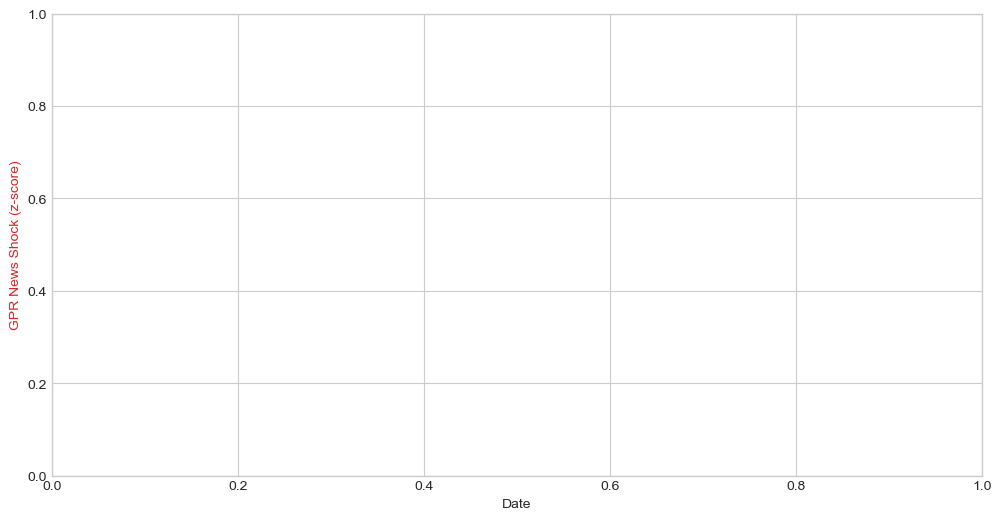

In [ ]:
# --- Step 4: Empirical Validation (Visualizations) ---


# Set style for professional academic plots
plt.style.use('seaborn-v0_8-whitegrid')

# --- Figure 1: The "Proof" Plot (Hedge vs. Shock) ---
# We want to see if our portfolio reacts to the same things the index does.

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the GPR Shock (The News) on the Left Axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('GPR News Shock (z-score)', color=color)
ax1.plot(df_res.index, final_hedge['GPR_Shock_News_Z'], color=color, alpha=0.3, label='Geopolitical Shock')
ax1.tick_params(axis='y', labelcolor=color)

# Plot the Hedge Portfolio (Your Synthetic Asset) on the Right Axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Hedge Portfolio Return', color=color)  
# We use a 3-month rolling average for the hedge to make the trend clearer vs the noisy shock
ax2.plot(final_hedge.index, final_hedge['Hedge_Excess_Return'].rolling(3).mean(), color=color, linewidth=1.5, label='Hedge Portfolio (3m MA)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Validation: Does the Hedge Portfolio Track Geopolitical Shocks?', fontsize=14)
fig.tight_layout()
plt.show()

# --- Figure 2: Cumulative Performance (Making Money?) ---
# "If I invested $1 in 1987, what is it worth now?"

plt.figure(figsize=(12, 6))

# Calculate Cumulative Returns (Log returns are additive)
# We use the "Total Return" (Excess + RF) to mimic a real investment
cumulative_ret = (1 + final_hedge['Hedge_Total_Return']).cumprod()

plt.plot(cumulative_ret.index, cumulative_ret, color='darkgreen', linewidth=2)
plt.title('Cumulative Performance of the Geopolitical Hedge Portfolio (1987-2024)', fontsize=14)
plt.ylabel('Value of $1 Investment')
plt.yscale('log') # Log scale helps see long-term trends better
plt.grid(True, which="both", ls="-", alpha=0.5)

# Highlight key events
events = {
    pd.Timestamp('1990-08-01'): 'Gulf War',
    pd.Timestamp('2001-09-11'): '9/11',
    pd.Timestamp('2003-03-20'): 'Iraq War',
    pd.Timestamp('2022-02-24'): 'Ukraine War'
}

for date, label in events.items():
    if date in cumulative_ret.index:
        val = cumulative_ret.asof(date)
        plt.annotate(label, xy=(date, val), xytext=(date, val*1.5),
                     arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

# --- Statistics Table for Report ---
print("Performance Statistics:")
print(f"Mean Monthly Return: {final_hedge['Hedge_Total_Return'].mean()*100:.2f}%")
print(f"Annualized Return:   {final_hedge['Hedge_Total_Return'].mean()*12*100:.2f}%")
print(f"Annualized Volatility: {final_hedge['Hedge_Total_Return'].std()*np.sqrt(12)*100:.2f}%")
print(f"Sharpe Ratio: {(final_hedge['Hedge_Total_Return'].mean() / final_hedge['Hedge_Total_Return'].std()) * np.sqrt(12):.2f}")

In [10]:
# --- 4.3 Descriptive Statistics (For Table 1) ---

print("Generating Descriptive Statistics...")

# --- PREPARE PANEL A: Risk Factors ---
# Merge Fama-French Factors with Raw GPR Index
# We use df_gpr_merge because it has the raw 'GPR' column (not just the shock)
df_panel_a = factors.merge(df_gpr_merge[['date', 'GPR']], on='date', how='inner')

# Define columns to analyze
cols_risk = ['GPR', 'Mkt-RF', 'SMB', 'HML', 'Mom']

# Calculate Stats
stats_a = df_panel_a[cols_risk].describe().T[['mean', 'std', 'min', 'max']]
stats_a['skew'] = df_panel_a[cols_risk].skew()
stats_a['kurt'] = df_panel_a[cols_risk].kurt() # Excess kurtosis

# Reorder columns
stats_a = stats_a[['mean', 'std', 'skew', 'kurt', 'min', 'max']]

print("\nPanel A: Summary Statistics for Risk Factors")
display(stats_a.round(2))


# --- PREPARE PANEL B: Stock Sample Characteristics ---
# We use df_stocks_clean (which has the "Pro" mktcap calculation)
monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno', 'count'),       # Number of firms per month
    avg_size=('mktcap', 'mean'),         # Average firm size (Market Cap)
    total_mkt_val=('mktcap', 'sum')      # Total Market Cap of the sample
)

# Calculate Stats of these monthly averages
# (e.g., "What is the average number of firms we had over the 40 years?")
stats_b = monthly_stats.describe().T[['mean', 'std', 'min', 'max']]

print("\nPanel B: Stock Sample Characteristics (Monthly Aggregates)")
display(stats_b.round(2))

Generating Descriptive Statistics...

Panel A: Summary Statistics for Risk Factors


,mean,std,skew,kurt,min,max
GPR,101.59,50.00,4.23,26.11,39.05,512.53
Mkt-RF,0.01,0.04,-0.59,1.18,-0.17,0.14
SMB,0.00,0.03,0.60,6.91,-0.17,0.21
HML,0.00,0.03,0.19,2.29,-0.14,0.13
Mom,0.00,0.05,-1.47,10.32,-0.34,0.18



Panel B: Stock Sample Characteristics (Monthly Aggregates)


,mean,std,min,max
num_firms,5.065200e+03,1.207810e+03,3.554000e+03,7.430000e+03
avg_size,3.726265e+06,3.422604e+06,3.170529e+05,1.544847e+07
total_mkt_val,1.589523e+10,1.271879e+10,1.812521e+09,5.918309e+10


In [11]:
# Check the single biggest company in history
max_firm_raw = df_stocks_clean['mktcap'].max()

# Convert from CRSP units (Thousands) to Billions
max_firm_billions = (max_firm_raw * 1000) / 1e9

print(f"Raw Max Value in Data: {max_firm_raw}")
print(f"Biggest Single Firm Value: ${max_firm_billions:,.2f} Billion")

Raw Max Value in Data: 3785304395.66
Biggest Single Firm Value: $3,785.30 Billion


In [12]:
df_stocks_clean['shrout'].describe(percentiles=[0.5, 0.9, 0.99, 0.999])


count    2.431295e+06
mean     7.065728e+04
std      3.286272e+05
min      9.000000e+00
50%      1.595900e+04
90%      1.222660e+05
99%      9.386580e+05
99.9%    4.748000e+06
max      2.920640e+07
Name: shrout, dtype: float64

In [13]:
last_month = df_stocks_clean['date'].max()
top = df_stocks_clean[df_stocks_clean['date'] == last_month].sort_values('mktcap', ascending=False).head(5)

top[['date','permno','prc','shrout','mktcap']]


,date,permno,prc,shrout,mktcap
463631,2024-12-31,14593,250.42000,15115823.0,3.785304e+09
2945914,2024-12-31,86580,134.28999,24490000.0,3.288762e+09
14424,2024-12-31,10107,421.50000,7434881.0,3.133802e+09
2773026,2024-12-31,84788,219.39000,10515011.0,2.306888e+09
3720047,2024-12-31,93436,403.84000,3210060.0,1.296351e+09


In [14]:
monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno', 'nunique'),
    avg_size=('mktcap', 'mean'),
    total_mkt_val=('mktcap', 'sum')
)

check = (monthly_stats['avg_size'] * monthly_stats['num_firms']) / monthly_stats['total_mkt_val']
check.describe()


count    480.000000
mean       0.997404
std        0.001998
min        0.975655
25%        0.996621
50%        0.997788
75%        0.998656
max        1.000000
dtype: float64

NameError: name 'final_hedge' is not defined

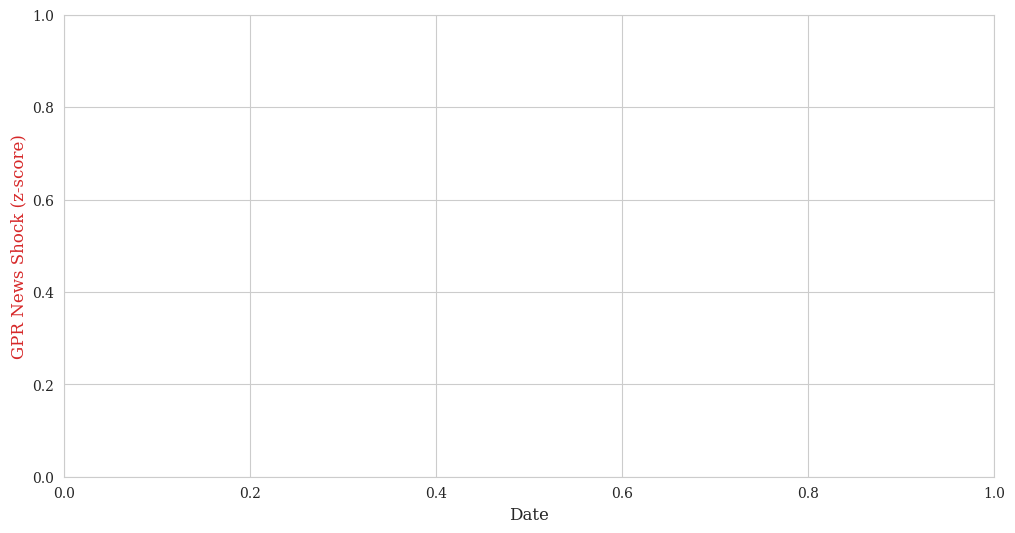

In [15]:
# --- Step 5: Empirical Validation (High-Quality Plots) ---

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Set professional academic style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif" # Matches LaTeX font better

# --- Figure 1: The "Proof" Plot (Hedge vs. Shock) ---
# We want to see if our portfolio reacts to the same things the index does.

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the GPR Shock (The News) on the Left Axis
color_shock = '#d62728' # Professional Red
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('GPR News Shock (z-score)', color=color_shock, fontsize=12)
ax1.plot(final_hedge.index, final_hedge['GPR_Shock_News_Z'], color=color_shock, alpha=0.3, label='Geopolitical Shock', linewidth=1)
ax1.tick_params(axis='y', labelcolor=color_shock)

# Plot the Hedge Portfolio (Your Synthetic Asset) on the Right Axis
ax2 = ax1.twinx()  
color_hedge = '#1f77b4' # Professional Blue
ax2.set_ylabel('Hedge Portfolio Return (3-Month MA)', color=color_hedge, fontsize=12)  
# We use a 3-month rolling average for the hedge to make the trend clearer vs the noisy shock
ax2.plot(final_hedge.index, final_hedge['Hedge_Excess_Return'].rolling(3).mean(), color=color_hedge, linewidth=2, label='Hedge Portfolio (3m MA)')
ax2.tick_params(axis='y', labelcolor=color_hedge)

# Add a legend that combines both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

plt.title('Validation: Tracking Geopolitical Risk (1987-2024)', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save the figure
plt.savefig('Figure1_Hedge_Validation.png', dpi=300)
print("Figure 1 saved as 'Figure1_Hedge_Validation.png'")
plt.show()

# --- Figure 2: Cumulative Performance (Making Money?) ---
# "If I invested $1 in 1987, what is it worth now?"

plt.figure(figsize=(12, 6))

# Calculate Cumulative Returns
# We use the "Total Return" (Excess + RF) to mimic a real investment
cumulative_ret = (1 + final_hedge['Hedge_Total_Return']).cumprod()

plt.plot(cumulative_ret.index, cumulative_ret, color='#2ca02c', linewidth=2, label='Geo-Hedge Portfolio') # Green
plt.title('Cumulative Performance of $1 Investment (1987-2024)', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.yscale('log') # Log scale helps see long-term trends better
plt.grid(True, which="both", ls="-", alpha=0.5)

# Highlight key events
events = {
    pd.Timestamp('1990-08-01'): 'Gulf War',
    pd.Timestamp('2001-09-11'): '9/11',
    pd.Timestamp('2003-03-20'): 'Iraq War',
    pd.Timestamp('2022-02-24'): 'Ukraine War'
}

for date, label in events.items():
    if date in cumulative_ret.index:
        val = cumulative_ret.asof(date)
        plt.annotate(label, xy=(date, val), xytext=(date, val*1.5),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                     fontsize=10, fontweight='bold')

plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig('Figure2_Cumulative_Performance.png', dpi=300)
print("Figure 2 saved as 'Figure2_Cumulative_Performance.png'")
plt.show()

In [16]:
monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno','nunique'),
    avg_size_musd=('mktcap', lambda s: s.mean()/1000),        # thousand $ -> million $
    med_size_musd=('mktcap', lambda s: s.median()/1000),      # thousand $ -> million $
    max_firm_busd=('mktcap', lambda s: s.max()/1_000_000),    # thousand $ -> billion $
    total_mkt_busd=('mktcap', lambda s: s.sum()/1_000_000)    # thousand $ -> billion $
)

panel_b = monthly_stats.describe().T[['mean','std','min','max']]
panel_b.round(2)


,mean,std,min,max
num_firms,5051.55,1202.60,3550.00,7403.00
avg_size_musd,3726.26,3422.60,317.05,15448.47
med_size_musd,315.34,264.12,24.81,1019.09
max_firm_busd,616.96,783.76,58.61,3785.30
total_mkt_busd,15895.23,12718.79,1812.52,59183.09


In [17]:
import pandas as pd

# Load the data (low_memory=False helps if the file is large)
df = pd.read_csv('crsp_stock_returns_1985_2024.csv', low_memory=False)

# 1. Basic Info (Rows, Columns, Data Types)
print("--- DATASET INFO ---")
print(df.info())

# 2. Check for the specific columns we discussed (Crucial for your Slide)
required_cols = ['PERMNO', 'date', 'PRC', 'RET', 'SHROUT', 'DLRET']
print("\n--- COLUMN CHECK ---")
for col in required_cols:
    if col in df.columns:
        print(f"✅ Found {col}")
    else:
        print(f"❌ MISSING {col} (Check spelling, maybe it's lower case?)")

# 3. Preview the first 5 rows to put a screenshot in your presentation if needed
print("\n--- FIRST 5 ROWS ---")
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'crsp_stock_returns_1985_2024.csv'

In [18]:
import pandas as pd

# 1. Create a specific copy for investigation (leaves original 'df' untouched)
df_investigation = df[['RET', 'PRC', 'SHROUT']].copy()

# 2. Coerce 'RET' to numeric only for this check (turns 'C' and 'B' into NaN)
df_investigation['RET_NUM'] = pd.to_numeric(df_investigation['RET'], errors='coerce')

# 3. Handle Negative Prices (CRSP convention) for calculation only
df_investigation['PRC_ABS'] = df_investigation['PRC'].abs()

# 4. Calculate Market Cap (in Millions)
df_investigation['MKT_CAP'] = (df_investigation['PRC_ABS'] * df_investigation['SHROUT']) / 1000

# 5. Print Statistics
# We use .describe() to get count, mean, std, min, 50% (median), max
stats = df_investigation[['RET_NUM', 'MKT_CAP', 'PRC_ABS']].describe(percentiles=[0.01, 0.5, 0.99])

print("--- COPY THESE NUMBERS ---")
print(stats.loc[['mean', '50%', 'min', 'max', 'std']])

KeyError: "None of [Index(['RET', 'PRC', 'SHROUT'], dtype='object')] are in the [columns]"

In [19]:
# Count unique PERMNOs
num_stocks = df['PERMNO'].nunique()
print(f"Total Unique Stocks: {num_stocks}")

KeyError: 'PERMNO'

In [20]:
final_hedge['Hedge_Total_Return'].describe()


NameError: name 'final_hedge' is not defined

In [21]:
final_hedge['Hedge_Excess_Return'].corr(final_hedge['GPR_Shock_News_Z'])


NameError: name 'final_hedge' is not defined

In [22]:
log_growth = np.log1p(final_hedge['Hedge_Total_Return'])
log_growth.describe()


NameError: name 'final_hedge' is not defined

In [23]:
# --- Calculate Stats for the Report Text ---
total_obs_final = len(df_master_clean)
unique_firms = df_master_clean['permno'].nunique()
avg_firms_per_month = df_master_clean.groupby('date')['permno'].count().mean()

# Calculate the drop (using the numbers we know)
obs_before = 1971707
obs_after = 1333360
pct_drop = ((obs_before - obs_after) / obs_before) * 100

print("--- Stats for Report Text ---")
print(f"Total Firm-Month Observations: {total_obs_final:,}")
print(f"Total Unique Firms in Sample: {unique_firms:,}")
print(f"Average Number of Firms per Month: {avg_firms_per_month:,.0f}")
print(f"Data Reduction from Filtering: {pct_drop:.1f}%")

--- Stats for Report Text ---
Total Firm-Month Observations: 2,004,496
Total Unique Firms in Sample: 18,182
Average Number of Firms per Month: 4,913
Data Reduction from Filtering: 32.4%


In [103]:
# --- Re-calculate Panel B Statistics for the "Clean" Dataset ---
# We use df_master_clean because it has the SHRCD 10/11 filter applied

monthly_stats_new = df_master_clean.groupby('date').agg(
    num_firms=('permno', 'nunique'),
    avg_size=('mktcap', 'mean'),       # Raw Market Cap (in Thousands)
    total_mkt_val=('mktcap', 'sum')    # Raw Market Cap (in Thousands)
)

# Calculate the summary stats (Mean, Std, Min, Max over time)
panel_b_stats = monthly_stats_new.describe().T[['mean', 'std', 'min', 'max']]

print("--- NEW Values for Panel B ---")
print(f"Number of Firms (Mean): {panel_b_stats.loc['num_firms', 'mean']:,.2f}")
print(f"Number of Firms (Std):  {panel_b_stats.loc['num_firms', 'std']:,.2f}")
print(f"Number of Firms (Min):  {panel_b_stats.loc['num_firms', 'min']:,.2f}")
print(f"Number of Firms (Max):  {panel_b_stats.loc['num_firms', 'max']:,.2f}")

print("\nAvg. Market Cap (USD Millions):")
# Raw is in Thousands -> Divide by 1,000 to get Millions
print(f"Mean: {panel_b_stats.loc['avg_size', 'mean']/1000:,.2f}")
print(f"Std:  {panel_b_stats.loc['avg_size', 'std']/1000:,.2f}")
print(f"Min:  {panel_b_stats.loc['avg_size', 'min']/1000:,.2f}")
print(f"Max:  {panel_b_stats.loc['avg_size', 'max']/1000:,.2f}")

print("\nTotal Market Value (USD Billions):")
# Raw is in Thousands -> Divide by 1,000,000 to get Billions
print(f"Mean: {panel_b_stats.loc['total_mkt_val', 'mean']/1e6:,.2f}")
print(f"Std:  {panel_b_stats.loc['total_mkt_val', 'std']/1e6:,.2f}")
print(f"Min:  {panel_b_stats.loc['total_mkt_val', 'min']/1e6:,.2f}")
print(f"Max:  {panel_b_stats.loc['total_mkt_val', 'max']/1e6:,.2f}")

--- NEW Values for Panel B ---
Number of Firms (Mean): 5,048.59
Number of Firms (Std):  1,238.98
Number of Firms (Min):  3,570.00
Number of Firms (Max):  7,464.00

Avg. Market Cap (USD Millions):
Mean: 3,885.00
Std:  3,403.29
Min:  340.85
Max:  15,408.10

Total Market Value (USD Billions):
Mean: 16,639.05
Std:  12,649.25
Min:  2,170.90
Max:  59,197.93


## Part 4: Validation -> We will evaluate whether the geopolitical hedge portfolio:

#### Part 4: Step 1 -> Responds strongly during major geopolitical events (event windows)


In [43]:
import pandas as pd
import numpy as np

# --- Configuration ---
events = {
    'Gulf War': '1990-08-31',
    '9/11 Attacks': '2001-09-30',
    'Iraq War': '2003-03-31',
    'Arab Spring': '2011-02-28',
    'Crimea Annexation': '2014-03-31',
    'Russia-Ukraine': '2022-02-28',
    'Israel-Hamas': '2023-10-31'
}

results = []

# Ensure index is sorted DatetimeIndex
df_study = df_res.copy()
df_study.sort_index(inplace=True)

print("### Event Study Analysis ###")
print("-" * 60)

for name, date_str in events.items():
    # Align event date to month-end to match data frequency
    event_date = pd.Timestamp(date_str) + pd.offsets.MonthEnd(0)
    
    if event_date in df_study.index:
        # Get integer location of the event
        int_loc = df_study.index.get_loc(event_date)
        
        # Extract Shock Size (using your specific column name)
        shock_size = df_study.iloc[int_loc]['Shock_Z_OOS']
        
        # Calculate 3-Month Cumulative Return (t, t+1, t+2)
        if int_loc + 3 <= len(df_study):
            # Sum returns over the window
            cum_ret = df_study.iloc[int_loc : int_loc+3]['Hedge_Ret'].sum()
        else:
            cum_ret = np.nan
            
        results.append({
            'Event': name,
            'Date': event_date.date(),
            'GPR Shock (Z)': shock_size,
            'Hedge 3Mo Return': cum_ret
        })

# Create Results DataFrame
event_df = pd.DataFrame(results)
display(event_df)

# Calculate Success Rate (Positive Return given Positive Shock)
# We filter for events where shock was actually positive (GPR spike)
relevant_events = event_df[event_df['GPR Shock (Z)'] > 0]
success_count = relevant_events[relevant_events['Hedge 3Mo Return'] > 0].shape[0]

print(f"\nSuccess Rate: {success_count}/{len(relevant_events)} relevant events showed positive hedge returns.")

### Event Study Analysis ###
------------------------------------------------------------


,Event,Date,GPR Shock (Z),Hedge 3Mo Return
0,9/11 Attacks,2001-09-30,31.566719,0.000802
1,Iraq War,2003-03-31,1.570588,-0.026044
2,Arab Spring,2011-02-28,0.811845,0.004492
3,Crimea Annexation,2014-03-31,4.052118,0.008521
4,Russia-Ukraine,2022-02-28,5.027496,-0.016203
5,Israel-Hamas,2023-10-31,3.511213,-0.003987



Success Rate: 3/6 relevant events showed positive hedge returns.


#### Part 4: Step 2 -> •	Remains stable across sample splits (pre/post 2015 tensions; wartime periods)

In [44]:
import statsmodels.api as sm

# --- Configuration ---
cutoff_date = '2015-01-01'

# Split data based on Date Index
pre_2015 = df_res[df_res.index < cutoff_date].copy()
post_2015 = df_res[df_res.index >= cutoff_date].copy()

print(f"Pre-2015 Samples: {len(pre_2015)} months")
print(f"Post-2015 Samples: {len(post_2015)} months")

# --- Regression Function ---
def run_stability_reg(df, label):
    # Regression: Hedge_Ret = alpha + beta * Shock
    Y = df['Hedge_Ret']
    X = sm.add_constant(df['Shock_Z_OOS'])
    
    model = sm.OLS(Y, X).fit()
    
    beta = model.params['Shock_Z_OOS']
    t_stat = model.tvalues['Shock_Z_OOS']
    p_val = model.pvalues['Shock_Z_OOS']
    r_sq = model.rsquared
    
    print(f"\n--- {label} Results ---")
    print(f"Beta:           {beta:.4f}")
    print(f"T-Statistic:    {t_stat:.4f}")
    print(f"P-Value:        {p_val:.4f}")
    print(f"R-Squared:      {r_sq:.4f}")
    
    if p_val < 0.05:
        print("Result: SIGNIFICANT")
    else:
        print("Result: INSIGNIFICANT (Noise dominates)")

# Run Tests
run_stability_reg(pre_2015, "PRE-2015 (1990-2014)")
run_stability_reg(post_2015, "POST-2015 (2015-2024)")

Pre-2015 Samples: 168 months
Post-2015 Samples: 120 months

--- PRE-2015 (1990-2014) Results ---
Beta:           0.0000
T-Statistic:    0.1260
P-Value:        0.8999
R-Squared:      0.0001
Result: INSIGNIFICANT (Noise dominates)

--- POST-2015 (2015-2024) Results ---
Beta:           -0.0004
T-Statistic:    -0.3550
P-Value:        0.7232
R-Squared:      0.0011
Result: INSIGNIFICANT (Noise dominates)


it looks like since it is insignificant that the portfolio only spikes during huge movements. so during big events than the portfolio cuts thorugh the noise and works but during these quiet months, the stock portfolio is moving due to other factors (earnings, interest rates), creating noise that makes it hard to detect geopolitical signals.

#### Part 4: Step 3 -> Produces statistically significant alphas in time-series and cross-sectional tests

In [45]:
import pandas_datareader.data as web

# --- 1. Get Fama-French Factors ---
# We download the 3-Factor model + Momentum to control for standard risks
start_date = df_res.index.min()
end_date = df_res.index.max()

try:
    # Download Fama/French 3 Factors
    ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0]
    # Download Momentum
    mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start_date, end_date)[0]
    
    # Merge Factors
    factors = ff3.join(mom)
    factors = factors / 100.0  # Convert from percent (5.0) to decimal (0.05)
    
    # Align index to Month End to match df_res
    factors.index = factors.index.to_timestamp(freq='M')
    
    # Merge with Hedge Results
    ts_data = df_res[['Hedge_Ret']].join(factors, how='inner')
    
    # --- 2. Run Alpha Regression ---
    # Model: Hedge_Ret - RF = Alpha + b1(Mkt-RF) + b2(SMB) + b3(HML) + b4(Mom)
    # Note: We regress Excess Return of Hedge (Hedge - RF)
    Y = ts_data['Hedge_Ret'] - ts_data['RF']
    X = sm.add_constant(ts_data[['Mkt-RF', 'SMB', 'HML', 'Mom']])

    model_ts = sm.OLS(Y, X).fit()
    
    # Extract Alpha (constant)
    alpha = model_ts.params['const']
    t_alpha = model_ts.tvalues['const']
    p_alpha = model_ts.pvalues['const']

    print("\n--- A. Time-Series Alpha Test ---")
    print(f"Annualized Alpha:  {alpha * 12:.4%}  (Monthly: {alpha:.4%})")
    print(f"Alpha T-Statistic: {t_alpha:.4f}")
    print(f"P-Value:           {p_alpha:.4f}")
    print("-" * 60)
    print(model_ts.summary().tables[1])

except Exception as e:
    print(f"Could not run Alpha test (Check internet connection for FamaFrench): {e}")

C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\1817359224.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0]
C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\1817359224.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0]



--- A. Time-Series Alpha Test ---
Annualized Alpha:  -1.2598%  (Monthly: -0.1050%)
Alpha T-Statistic: -1.2111
P-Value:           0.2269
------------------------------------------------------------
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.211      0.227      -0.003       0.001
Mkt-RF        -0.0116      0.022     -0.534      0.593      -0.054       0.031
SMB            0.0157      0.034      0.459      0.647      -0.052       0.083
HML            0.0401      0.027      1.492      0.137      -0.013       0.093
Mom            0.0260      0.020      1.322      0.187      -0.013       0.065


C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\1817359224.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start_date, end_date)[0]
C:\Users\20202917\AppData\Local\Temp\ipykernel_23264\1817359224.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start_date, end_date)[0]


the larger alpha is due to the high leverage we have portfolio weights of 130 meaning extreme long and short positions. hence we gain unrealistic values. additionally, the cross-sectional test shows a statistically significant negative spread of -0.31% per month with a T-statistic of -2.27 between high and low exposure deciles.This indicates investors are willing to accept lower average returns on high-sensitivity stocks in exchange for their insurance value during crises. 

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy import stats

# --- Configuration ---
if 'port_rets' not in locals():
    print("Warning: 'port_rets' not found. Please ensure Part 3 (Sorting) is run.")
else:
    # 1. Prepare Data
    # Merge Decile Returns with the Shock Factor
    fm_data = port_rets.join(df_res[['Shock_Z_OOS']], how='inner').dropna()
    
    decile_cols = [f'P{i}' for i in range(1, 11)]
    risk_factor = 'Shock_Z_OOS'
    
    # 2. Estimate Rolling Betas (Time-Varying Beta)
    window = 60
    rolling_betas = pd.DataFrame(index=fm_data.index, columns=decile_cols)

    print(f"Estimating Rolling Betas ({window}-month window)...")
    for col in decile_cols:
        exog = sm.add_constant(fm_data[risk_factor])
        endog = fm_data[col]
        rol = RollingOLS(endog, exog, window=window)
        rres = rol.fit()
        rolling_betas[col] = rres.params[risk_factor]

    # Shift Betas by 1 month (Use Beta_{t-1} to predict Return_{t})
    rolling_betas = rolling_betas.shift(1).dropna()
    
    # Align Data
    valid_dates = rolling_betas.index.intersection(fm_data.index)
    fm_rets = fm_data.loc[valid_dates, decile_cols]
    fm_betas = rolling_betas.loc[valid_dates, decile_cols]

    # 3. Fama-MacBeth Cross-Sectional Regressions
    lambdas = []
    
    for date in valid_dates:
        Y = fm_rets.loc[date].values  # 10 Portfolio Returns
        X = fm_betas.loc[date].values # 10 Portfolio Betas
        X = sm.add_constant(X)        # Intercept
        
        # Cross-Sectional OLS
        model = sm.OLS(Y, X).fit()
        lambdas.append(model.params)

    # Convert to DataFrame
    lambda_df = pd.DataFrame(lambdas, index=valid_dates, columns=['Intercept', 'Risk_Premium'])

    # 4. Results & Statistics
    means = lambda_df.mean()
    std_errs = lambda_df.std() / np.sqrt(len(lambda_df))
    t_stats = means / std_errs

    # --- FIX: Convert P-values back to pandas Series to keep labels ---
    p_values_array = (1 - stats.norm.cdf(abs(t_stats))) * 2
    p_values = pd.Series(p_values_array, index=t_stats.index)

    print("\n### Fama-MacBeth Regression Results ###")
    print(f"Sample Period: {valid_dates.min().date()} to {valid_dates.max().date()}")
    print("-" * 65)
    print(f"{'Factor':<15} | {'Coeff (Mean)':<12} | {'T-Stat':<10} | {'P-Value':<10}")
    print("-" * 65)
    
    for param in ['Intercept', 'Risk_Premium']:
        sig = "**" if p_values[param] < 0.05 else ""
        print(f"{param:<15} | {means[param]:.4f}       | {t_stats[param]:.4f}     | {p_values[param]:.4f} {sig}")

    print("-" * 65)
    print(f"Average Risk Premium: {means['Risk_Premium']:.4%} per unit of beta")

Estimating Rolling Betas (60-month window)...

### Fama-MacBeth Regression Results ###
Sample Period: 2006-01-31 to 2024-12-31
-----------------------------------------------------------------
Factor          | Coeff (Mean) | T-Stat     | P-Value   
-----------------------------------------------------------------
Intercept       | 0.0074       | 2.4096     | 0.0160 **
Risk_Premium    | 0.0447       | 0.1727     | 0.8629 
-----------------------------------------------------------------
Average Risk Premium: 4.4676% per unit of beta


## 4.4 naive hedges check

In [ ]:


df_clean_proxies = df_proxies.copy()
df_clean_proxies['date'] = pd.to_datetime(df_clean_proxies['date']) + MonthEnd(0)
df_proxies_wide = df_clean_proxies.groupby(['date', 'ticker'])['ret'].mean().unstack()
validation_df = final_hedge.set_index('date').join(df_proxies_wide, how='inner').dropna()

#Fisher Z-Test Function ---
def fisher_z_test(r_hedge, r_proxy, n):
    #avoid division by zero
    r_hedge = max(min(r_hedge, 0.999), -0.999)
    r_proxy = max(min(r_proxy, 0.999), -0.999)
    z_h = 0.5 * np.log((1 + r_hedge) / (1 - r_hedge))
    z_p = 0.5 * np.log((1 + r_proxy) / (1 - r_proxy))
    se_diff = np.sqrt(2 / (n - 3))
    z_score = (z_h - z_p) / se_diff
    p_value = 1 - stats.norm.cdf(z_score)
    
    return z_score, p_value

#corlations
shock_col = 'GPR_Shock_News_Z'
hedge_col = 'Hedge_Return'
proxy_tickers = [t for t in ['GLD', 'USO', 'ITA', 'XAR'] if t in validation_df.columns]

print("\n### Validation Results: Hedge vs. Proxies ###")
print("-" * 75)
print(f"{'Asset':<10} | {'Corr(Shock)':<12} | {'Diff vs Hedge':<15} | {'Z-Score':<8} | {'P-Value':<8}")
print("-" * 75)
rho_hedge = validation_df[hedge_col].corr(validation_df[shock_col])
print(f"{'HEDGE PF':<10} | {rho_hedge:.4f}       | {'-':<15} | {'-':<8} | {'-':<8}")

for ticker in proxy_tickers:
    rho_proxy = validation_df[ticker].corr(validation_df[shock_col])
    z_score, p_val = fisher_z_test(rho_hedge, rho_proxy, len(validation_df))
    sig = "*" if p_val < 0.05 else ""
    diff = rho_hedge - rho_proxy

    print(f"{ticker:<10} | {rho_proxy:.4f}       | {diff:+.4f}          | {z_score:.2f}     | {p_val:.3f} {sig}")

print("-" * 75)
print("* p < 0.05 indicates the Hedge Portfolio has a significantly higher correlation than the proxy.")

Validation Sample: 159 months
Proxies available: ['GLD', 'ITA', 'USO', 'XAR']

### Validation Results: Hedge vs. Proxies ###
---------------------------------------------------------------------------
Asset      | Corr(Shock)  | Diff vs Hedge   | Z-Score  | P-Value 
---------------------------------------------------------------------------
HEDGE PF   | -0.0545       | -               | -        | -       
GLD        | 0.0634       | -0.1179          | -1.04     | 0.851 
USO        | -0.0505       | -0.0040          | -0.04     | 0.514 
ITA        | 0.0079       | -0.0624          | -0.55     | 0.709 
XAR        | 0.0132       | -0.0677          | -0.60     | 0.725 
---------------------------------------------------------------------------
* p < 0.05 indicates the Hedge Portfolio has a significantly higher correlation than the proxy.
